In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
test_csv = pd.read_csv("/opt/ml/dataset/test/test_data.csv")
submission_csv = pd. read_csv("./prediction/submission.csv")
sota_csv = pd.read_csv("./prediction/submission_jh.csv")

## 1. "예측 / SOTA 값" 비교 (태일)

In [6]:
sentences = test_csv["sentence"]
subject_entities, object_entities = test_csv["subject_entity"], test_csv["object_entity"] 
my_labels = submission_csv["pred_label"]
sota_labels = sota_csv["pred_label"]

In [8]:
i = -1
cnt = 0
while i < 50: # 전체 텍스트: len(my_labels) - 1
    i += 1
    if my_labels[i] == sota_labels[i]:
        continue
    cnt += 1
    print(f"{cnt}: {sentences[i]}")
    print(f"sub:{eval(subject_entities[i])['word']}, obj:{eval(object_entities[i])['word']}")
    print(f"예측: {my_labels[i]}, sota: {sota_labels[i]}")
    print()
print(f"num of diff: {cnt} / {i}")

1: 지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.
sub:MBC, obj:탐사기획 스트레이트
예측: no_relation, sota: org:product

2: 문재인 대통령 부인 김정숙 여사는 22일부터 1박2일 일정으로 광주를 방문해 경기를 관람하고 응원한다.
sub:문재인, obj:김정숙
예측: no_relation, sota: per:spouse

3: 조선민주주의인민공화국 관할 지역은 개풍군 영북면 월고리 및 연천군 서남면 지역을 합쳐 장풍군이 설치되어 있다.
sub:조선민주주의인민공화국, obj:개풍군
예측: org:place_of_headquarters, sota: org:members

4: 소련군에서 그의 이름도 중국식의 진지첸으로 조선인으로서의 정체성도 희박했다.
sub:소련군, obj:진지첸
예측: no_relation, sota: org:top_members/employees

5: 또, 한명진 예비후보는 “2003년 노무현 대통령의 ‘다음 5년 내지 10년 동안 먹고 살 수 있는 먹거리’를 준비하라는 지시로 또 다른 미래 투자인 우주개발 예산을 검토했다”라며 “우리의 국가방위 차원뿐만 아니라 우리나라의 방산물자 수출도 지속적으로 증대되고 있기 때문에 드론과 첨단 우주항공 방위산업단지는 국가적으로도 필요하다”라고 했다.
sub:한명진, obj:노무현
예측: no_relation, sota: per:colleagues

6: 이날 기탁식에서는 ㈜와이엔텍(회장 박용하) 1억 원, ㈜거명이앤씨(회장 반재경)가 1천만 원의 소중한 후원금을 전달하며 따뜻한 마음을 전했다.
sub:㈜거명이앤씨, obj:반재경
예측: no_relation, sota: org:top_members/employees

7: 이번 행사에 참여한 광주여대 재학생은 "평소 관심이 있던 마케팅·브랜드 분야의 현직자와 만나 소통할 수 있는 것도 의미 있었으며 진심어린 조언에 힘을 얻었다"고 말했다.
sub:광주여대, obj:재학생
예측: no_relatio

## 다른 부분 csv파일로 뽑기 (나연 추가)

In [ ]:
from load_data import *
from train import *

res_df = pd.DataFrame()
res_df['sentence'] = test_csv['sentence']
res_df['sub'] = test_csv["subject_entity"]
res_df['obj'] = test_csv["object_entity"] 

res_df['sota'] = sota_csv["pred_label"]
res_df['my'] = submission_csv["pred_label"]

diff_df = res_df[res_df['sota'] != res_df['my']]  # sota와 다른 부분만
diff_df.to_csv("sub_eda.csv", index=False, encoding="utf-8-sig")  # 저장
diff_df


## 2. Check for Submission Distribution (찬국)
현재 자신의 모델이 잘 예측되었는지 시각적으로 확인하기 위한 코드입니다.  
해당 코드는 'no-relation으로 예측한 결과가 적으면, 그만큼 다른 label을 예측할 수 있기에 좋은 성능을 기대할 수 있을 것이다'라는 가설을 바탕으로 작성되었습니다.  
비교를 위해 리더보드에서 f1-score 70점을 달성한 재학님의 모델 예측 결과와 현재 자신의 submission의 분포를 비교할 수 있습니다.  
- 해당 코드는 distribution 확인을 위한 코드입니다. 기준 예측 결과는 추후 개선할 수 있습니다. 

In [9]:
# first_dataset
label_jh = sota_csv.groupby('pred_label').count().sort_values(by = 'id', ascending=False)
label_jh.reset_index(level=['pred_label'], inplace = True)
label_jh.drop('probs', axis=1, inplace=True)
label_jh.columns = ["pred_label", "count"]

In [10]:
# second_dataset
label = submission_csv.groupby('pred_label').count().sort_values(by = 'id', ascending=False)
label.reset_index(level=['pred_label'], inplace = True)
label.drop('probs', axis=1, inplace=True)
label.columns = ["pred_label", "count"]

## 2-1.Distribution

Text(0.5, 1.0, 'Submission Distribution')

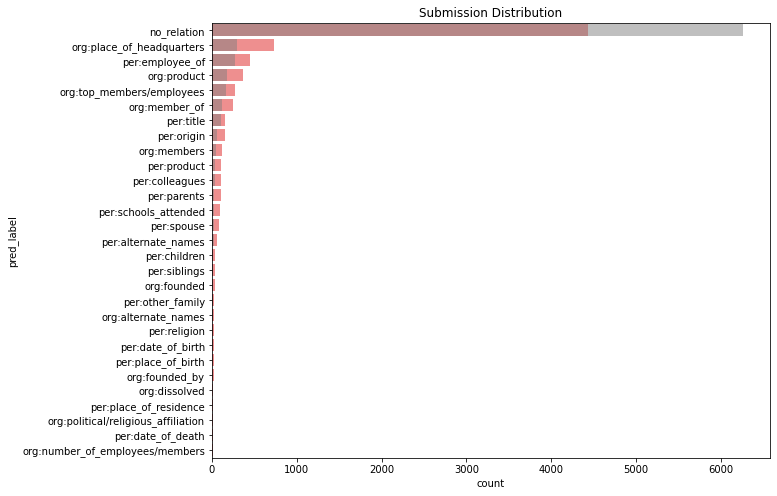

In [11]:
# 병렬적으로 확인하고 싶다면, subplot을 1,2로 주고 0ax 부분을 주석해제시키면 됩니다. 
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.barplot(y='pred_label', x='count', data=label_jh, # ax = axes[0],
              color='red',alpha=0.5 ) # pallete:

sns.barplot(y='pred_label', x='count', data=label, # ax = axes[1]
              color='gray',alpha=0.5 )
plt.title("Submission Distribution")

## 2-2.Difference

In [12]:
diff = label_jh['count'] - label['count']
diff_df =pd.DataFrame({"pred_label": label_jh['pred_label'], "diff":diff})

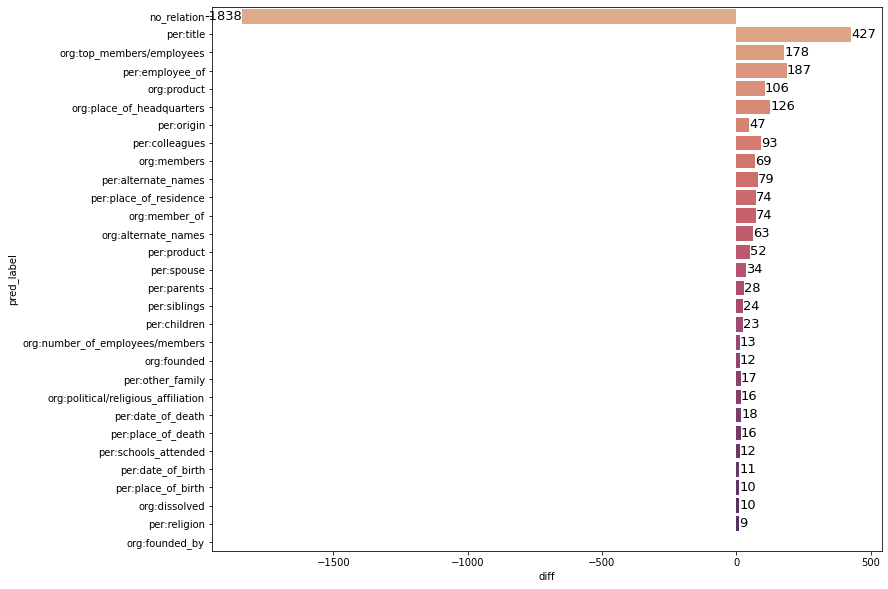

In [13]:
# 병렬적으로 확인하고 싶다면, subplot을 1,2로 주고 0ax 부분을 주석해제시키면 됩니다. 
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(y='pred_label', x='diff', data=diff_df, # ax = axes[0],
              palette='flare')

for i in ax.containers:
    ax.bar_label(i, fontsize=13)